# Take Home Assignment - Ziming Wang

## Outline:

* Question 1 [The most common location for each of the top 20 ticket infraction types](#question_1)

* Question 2 [The closest green P lot for each of the 20 locations](#question_2)

* Question 1 and 2 Result [Map of Question 1 and 2](#map_question1_2)

* Question 3 [Relevant socio-demographic observation(s) related to common ticket infractions](#question_3)

In [1]:
import requests
import json
import pandas as pd
import zipfile
import glob
import numpy as np

## <a name='question_1'></a>Question 1: Find the most common location for each of the top 20 ticket infraction types (1 location for each type)
1. Import Parking tickets data
2. Clean and Process data(handle duplicates and missing values)
3. Find the most common locations for top 20 infraction

### Q1.Step1: Import Parking Tickets data (2016-2020) 

In [2]:
# To hit API, making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = { "id": "parking-tickets"}
package = requests.get(url, params = params).json()

In [3]:
# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]): 
    
    # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        year = int(resource['name'][-4:]) if resource['name'][-4:].isnumeric() else 0
        resource_metadata = requests.get(url).json()     
        
        # download data between 2016 and 2020:       
        if year <= 2020 and year >= 2016:
            response = requests.get(resource_metadata['result']['url'])
            
            if response.status_code == 200:
                print("Data Loaded Successfully")
            else:
                print("Failed to load data")
            
            # write the content of the response to a file             
            with open(f'datasets\parking-tickets-{year}.zip', 'wb') as f:
                f.write(response.content)
            
            # open the zip file, and extract the contents             
            with zipfile.ZipFile(f'datasets\parking-tickets-{year}.zip', 'r') as zip_ref:
                zip_ref.extractall(path='datasets/')


Data Loaded Successfully
Data Loaded Successfully
Data Loaded Successfully
Data Loaded Successfully
Data Loaded Successfully


### Q1.Step2 Data Processing

In [4]:
# Read all ticketing CSV Files into one single DataFrame
path = 'datasets/'
ticketing_files = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in ticketing_files)
ticket_df = pd.concat(df_list, ignore_index=True)
print('Ticketing Dataframe:')
ticket_df.head()

Ticketing Dataframe:


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***03850,20160101,29.0,PARK PROHIBITED TIME NO PERMIT,30,0.0,NR,49 GLOUCESTER ST,NaN,NaN,ON
1,***03851,20160101,29.0,PARK PROHIBITED TIME NO PERMIT,30,1.0,NR,45 GLOUCESTER ST,NaN,NaN,ON
2,***98221,20160101,29.0,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,274 GEORGE ST,NaN,NaN,ON
3,***85499,20160101,29.0,PARK PROHIBITED TIME NO PERMIT,30,2.0,NR,270 GEORGE ST,NaN,NaN,ON
4,***03852,20160101,406.0,PARK-VEH. W/O VALID ONT PLATE,40,2.0,NR,45 GLOUCESTER ST,NaN,NaN,ON


### Check Duplicates in Parking Tickets DataFrame

In [5]:
# check duplicates
print('Are there any duplicates in the ticketing dataframe?')
ticket_df.duplicated().any()

Are there any duplicates in the ticketing dataframe?


True

In [6]:
# Find duplicates
duplicate = ticket_df[ticket_df.duplicated(keep = False)]
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
4799656,***49522,20180317,29.0,PARK PROHIBITED TIME NO PERMIT,30,1758.0,NR,8 ST HILDA'S AVE,NaN,NaN,ON
4799660,***49522,20180317,29.0,PARK PROHIBITED TIME NO PERMIT,30,1758.0,NR,8 ST HILDA'S AVE,NaN,NaN,ON
4956197,***54959,20180414,3.0,PARK ON PRIVATE PROPERTY,30,346.0,NaN,710 TRETHEWEY DRIVE,NaN,NaN,ON
4956199,***54959,20180414,3.0,PARK ON PRIVATE PROPERTY,30,346.0,NaN,710 TRETHEWEY DRIVE,NaN,NaN,ON


In [7]:
# Remove duplicates
ticket_df = ticket_df.drop_duplicates()
check_duplicate = ticket_df[ticket_df.duplicated(keep = False)]
print('Are there any duplicates in the ticketing dataframe?')
check_duplicate.duplicated().any()

Are there any duplicates in the ticketing dataframe?


False

### Handle Missing Values

In [8]:
# missing values for each column
ticket_df.isna().sum()

tag_number_masked               0
date_of_infraction              0
infraction_code                 2
infraction_description          0
set_fine_amount                 0
time_of_infraction           7473
location1                  961634
location2                    1157
location3                 9361612
location4                 9359362
province                        3
dtype: int64

#### Based on the value above, chooce 'location2' to represent location because 'location2' have the least NaN among other locations

#### Remove all rows without any location information(only care about location2 and location4) and return a new df

In [9]:
columns_to_check = ['location2','location4']

# Use the .isna() method to check for NaN values in the specified columns
nan_mask = ticket_df[columns_to_check].isna()

# Use the .all() method to check if any of the values in the specified columns are NaN
nan_rows = nan_mask.all(axis=1)

In [10]:
# Remove all rows without any location information
df = ticket_df.drop(ticket_df[nan_rows].index)

In [11]:
# check updated missing value
df.isna().sum()

tag_number_masked               0
date_of_infraction              0
infraction_code                 2
infraction_description          0
set_fine_amount                 0
time_of_infraction           7352
location1                  960576
location2                       9
location3                 9360464
location4                 9358214
province                        3
dtype: int64

#### There are still 9 rows without location2 value, for those rows, impute missing values using the location4 value

In [12]:
df.location2.fillna(df.location4,inplace=True)
# check updated missing value after imputing
df.isna().sum()

tag_number_masked               0
date_of_infraction              0
infraction_code                 2
infraction_description          0
set_fine_amount                 0
time_of_infraction           7352
location1                  960576
location2                       0
location3                 9360464
location4                 9358214
province                        3
dtype: int64

#### Now, all rows in column 'location2' have values and ready for analysis

### Q1.Step3 Analysis to find the most common location for each of the top 20 ticket infraction types

In [13]:
# For each infraction type, find the most common place:
common_place = df.groupby(['infraction_description'])['location2'].agg(pd.Series.mode)
print(common_place)

infraction_description
ANGLE PARK-METERED SPACE-FRONT              [273 BLOOR ST W, 4950 YONGE ST]
ANGLE PARK-TOO FAR FROM METER                                799 MILNER AVE
ANGLE PARK-TOO FAR FROM METER                                  56 WARREN RD
FAIL ANGLE PARK/STOP AT 45 DEG                                215 MAVETY ST
FAIL PARK/STOP PAR RT HAND LTD                                52 ROEBUCK DR
                                                    ...                    
STOP/STAND/PARK - NO VEND ZONE    [1305 LAWRENCE AVE W, 700 LAWRENCE AVE W]
STOP/STAND/PARK DESIGNATE AREA             [502 SPADINA AVE, 5915 YONGE ST]
STOP/STAND/PARK NOT DESIG AREA                              30 ST DENNIS DR
STOP/STAND/PARK VEND CONT ZONE                            36 DUNMURRAY BLVD
STOP/STAND/PARK VEND NO PERMIT                                 1 BRIMLEY RD
Name: location2, Length: 277, dtype: object


#### Find the top 20 infraction type based on df['infraction_description'] or df['infraction_code']

In [14]:
# Find the top 20 infraction type based on infraction_description
top_20 = df['infraction_description'].value_counts().nlargest(20)
top_20

PARK ON PRIVATE PROPERTY          1923742
PARK-SIGNED HWY-PROHIBIT DY/TM    1657432
PARK PROHIBITED TIME NO PERMIT    1413688
PARK MACHINE-REQD FEE NOT PAID    1117041
STOP-SIGNED HWY-PROHIBIT TM/DY     494633
PARK - LONGER THAN 3 HOURS         448140
PARK-VEH. W/O VALID ONT PLATE      363174
STAND VEH.-PROHIBIT TIME/DAY       346030
STOP-SIGNED HIGHWAY-RUSH HOUR      302088
PARK-SIGNED HWY-EXC PERMT TIME     278778
PARK FAIL TO DISPLAY RECEIPT       213395
PARK-WITHIN 3M OF FIRE HYDRANT     141912
PARK-N.YORK 2AM-6AM DEC1-MAR31     126238
PARK - LONGER THAN 3 HOURS         116499
STAND SIGNED TRANSIT STOP          102995
PARK ON MUNICIPAL PROPERTY          90358
PARKING MACH-NOT USED/NO FEE        88535
PARK COMMERC LOAD ZONE NOT LDG      83467
STOP-(ON/OVER) (SIDEWK/FTPATH)      68403
PARK IN A FIRE ROUTE                64687
Name: infraction_description, dtype: int64

In [15]:
# Find the top 20 infraction type based on infraction_code
top_20_code = df['infraction_code'].value_counts().nlargest(20)
top_20_code

3.0      1923827
5.0      1657531
29.0     1413693
207.0    1117041
2.0       564638
9.0       494672
406.0     363175
8.0       346041
403.0     302089
6.0       278797
210.0     213395
15.0      141925
28.0      126238
312.0     109692
192.0     102995
4.0        90411
415.0      83467
30.0       68411
347.0      64687
134.0      62835
Name: infraction_code, dtype: int64

#### Based on parking ticket data readme file, both 'infraction_code' and 'infraction_description' represents the infraction type.Theoretically speaking, the value count of these two columns should be the same. 
#### However the above analysis shows that the value counts has inconsistencies, and there is no extra information to support which column can represent the infraction type better.
#### Thus, I select 'infraction_description' to make the column more descriptive.

### Result Table: The most common location for each of the top 20 ticket infraction types are shown below:
(maps are shown later in the notebook)

In [16]:
top_20_infraction_most_common_place = common_place[top_20.index]
print(top_20_infraction_most_common_place)

PARK ON PRIVATE PROPERTY                  2075 BAYVIEW AVE
PARK-SIGNED HWY-PROHIBIT DY/TM                20 EDWARD ST
PARK PROHIBITED TIME NO PERMIT             100 MAITLAND ST
PARK MACHINE-REQD FEE NOT PAID         15 MARINE PARADE DR
STOP-SIGNED HWY-PROHIBIT TM/DY             42 CHARLES ST E
PARK - LONGER THAN 3 HOURS                   12 SUDBURY ST
PARK-VEH. W/O VALID ONT PLATE          15 MARINE PARADE DR
STAND VEH.-PROHIBIT TIME/DAY           19 GRAND TRUNK CRES
STOP-SIGNED HIGHWAY-RUSH HOUR                33 COLLEGE ST
PARK-SIGNED HWY-EXC PERMT TIME                2 SUSSEX AVE
PARK FAIL TO DISPLAY RECEIPT           15 MARINE PARADE DR
PARK-WITHIN 3M OF FIRE HYDRANT             99 ATLANTIC AVE
PARK-N.YORK 2AM-6AM DEC1-MAR31    100 HARRISON GARDEN BLVD
PARK - LONGER THAN 3 HOURS            151 VILLAGE GREEN SQ
STAND SIGNED TRANSIT STOP                   720 QUEEN ST W
PARK ON MUNICIPAL PROPERTY                   18 HENDON AVE
PARKING MACH-NOT USED/NO FEE                1155 KING ST

## <a name='question_2'></a>Question 2: Find the closest green P lot for each of the 20 locations:


1. Convert the street names of the 20 locations to latitude and longitude coordinates using a geocoding service.
2. Import Green P Parking data
<!-- 2. For each location, iterate over the parking lot JSON file and calculate the distance (using Haversine formula) between the location and each parking lot. -->
3. For each location, find the parking lot with the shortest distance and store it as the closest parking lot.

In [17]:
# Convert to a dataframe for convinence
top_20_df = top_20_infraction_most_common_place.to_frame()

### Q2.Step1 Convert the street names of the 20 locations to latitude and longitude coordinates using a geocoding service

In [18]:
# Convert the street names of the 20 locations to latitude and longitude coordinates using a geocoding service
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="dataProject")

for ind in top_20_df.index:
    location = geolocator.geocode(top_20_df['location2'][ind]+' Toronto')
    top_20_df.loc[ind,'lat']= location.latitude
    top_20_df.loc[ind,'long']= location.longitude

top_20_df

,location2,lat,long
PARK ON PRIVATE PROPERTY,2075 BAYVIEW AVE,43.722859,-79.375661
PARK-SIGNED HWY-PROHIBIT DY/TM,20 EDWARD ST,43.656941,-79.382067
PARK PROHIBITED TIME NO PERMIT,100 MAITLAND ST,43.665087,-79.379675
PARK MACHINE-REQD FEE NOT PAID,15 MARINE PARADE DR,43.629106,-79.475411
STOP-SIGNED HWY-PROHIBIT TM/DY,42 CHARLES ST E,43.669416,-79.384221
PARK - LONGER THAN 3 HOURS,12 SUDBURY ST,43.641575,-79.418291
PARK-VEH. W/O VALID ONT PLATE,15 MARINE PARADE DR,43.629106,-79.475411
STAND VEH.-PROHIBIT TIME/DAY,19 GRAND TRUNK CRES,43.641681,-79.383041
STOP-SIGNED HIGHWAY-RUSH HOUR,33 COLLEGE ST,43.660745,-79.385422
PARK-SIGNED HWY-EXC PERMT TIME,2 SUSSEX AVE,43.665640,-79.399534


### Q2.Step2 Import Green P Parking data (using 2019 since it is the latest)

In [19]:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
url = base_url + "/api/3/action/package_show"
params_parking = { "id": "green-p-parking"}
package_parking = requests.get(url, params = params_parking).json()

In [20]:
for idx, resource in enumerate(package_parking["result"]["resources"]):
 
    # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        
        parking_lot_filename = resource['url'].split('/')[-1]
        
        year = int(resource['name'][-4:]) if resource['name'][-4:].isnumeric() else resource['name'][-4:]
        
        resource_metadata_parking = requests.get(url).json()
        
        if year == 2019:
            response = requests.get(resource_metadata_parking['result']['url'])
            if response.status_code == 200:
                print("Data Loaded Successfully")
            else:
                print("Failed to load data")
            
            json_object = json.dumps(response.json(), indent=4)
            
            with open(parking_lot_filename, 'w') as f:
                f.write(json_object)
            
            

Data Loaded Successfully


In [21]:
# open the file and convert to dataframe
with open('green-p-parking-2019.json') as file:
    data = json.load(file)
reff = pd.json_normalize(data['carparks'])
parking_df = pd.DataFrame(data=reff)
parking_df.head()

,id,slug,address,lat,lng,rate,carpark_type,carpark_type_str,is_ttc,is_under_construction,...,map_marker_logo,alert_box,enable_streetview,streetview_lat,streetview_long,streetview_yaw,streetview_pitch,streetview_zoom,rate_details.periods,rate_details.addenda
0,1,https://parking.greenp.com/carpark/1_20-charle...,20 Charles Street East,43.669282202140174,-79.3852894625656,$2.50 / Half Hour,garage,Garage,False,False,...,greenp_only,Monthly Permits are no longer available at thi...,yes,43.669282202140174,-79.3852894625656,321.21,-12.45,0,"[{'title': 'Monday - Sunday & Holidays', 'rate...",[]
1,3,https://parking.greenp.com/carpark/3_13-isabel...,13 Isabella Street,43.667577,-79.384707,$3.00 / Half Hour,surface,Surface,False,False,...,greenp_only,,yes,43.667735,-79.384966,115.84,7.51,0,"[{'title': 'Monday - Sunday & Holidays', 'rate...",[]
2,5,https://parking.greenp.com/carpark/5_15-welles...,15 Wellesley Street East,43.664837,-79.383591,$3.00 / Half Hour,surface,Surface,False,False,...,greenp_bikeshare,,yes,43.665083,-79.383807,138.09,-4.68,0,"[{'title': 'Monday - Sunday & Holidays', 'rate...",[]
3,11,https://parking.greenp.com/carpark/11_21-pleas...,21 Pleasant Blvd.,43.687092,-79.392850,$3.00 / Half Hour,garage,Garage,False,False,...,greenp_only,,yes,43.686491,-79.392056,280.08,-13.18,0,"[{'title': 'Monday - Sunday & Holidays', 'rate...",[]
4,12,https://parking.greenp.com/carpark/12_30-alvin...,30 Alvin Avenue,43.68919056469554,-79.39269983525526,$3.50 / Half Hour,surface,Surface,False,False,...,greenp_only,,yes,43.68919056469554,-79.39269983525526,330.84,1.32,0,[{'title': 'Day Maximum until 6 PM - $25.00 (E...,[]


### Q2.Step3 For each location, find the parking lot with the shortest distance and store it as the closest parking lot.

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint
import numpy as np

In [23]:
# convert parking dataframe to geodataframe
gdf_parking = gpd.GeoDataFrame(
    parking_df, geometry=gpd.points_from_xy(parking_df.lng, parking_df.lat))
gdf_parking = gdf_parking.set_crs('epsg:4326')

C:\Users\wzmca\anaconda3\envs\test\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [24]:
# convert top_20_df dataframe to geodataframe
gdf_top_20 = gpd.GeoDataFrame(
    top_20_df, geometry=gpd.points_from_xy(top_20_df.long, top_20_df.lat))
gdf_top_20 = gdf_top_20.set_crs('epsg:4326')

C:\Users\wzmca\anaconda3\envs\test\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [25]:
# Returns a geometry containing the union of all geometries
unary_union = gdf_parking.unary_union

In [26]:
# define a function to calculate the nearest point
def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].values
    return value

### Result Table: the closest green P lot for each of the 20 locations
(maps are shown later in the notebook)

In [27]:
# call the nearest function and add the nearest parking information to the top_20 geodataframe
gdf_top_20['nearest_parking'] = gdf_top_20.apply(nearest, geom_union=unary_union, df1=gdf_top_20, df2=gdf_parking, geom1_col='geometry', src_column='address', axis=1)
gdf_top_20['parking_lat'] = gdf_top_20.apply(nearest, geom_union=unary_union, df1=gdf_top_20, df2=gdf_parking, geom1_col='geometry', src_column='lat', axis=1)
gdf_top_20['parking_long'] = gdf_top_20.apply(nearest, geom_union=unary_union, df1=gdf_top_20, df2=gdf_parking, geom1_col='geometry', src_column='lng', axis=1)
gdf_top_20['parking_geometry']=gpd.points_from_xy(gdf_top_20.parking_long, gdf_top_20.parking_lat)
gdf_top_20

C:\Users\wzmca\anaconda3\envs\test\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,location2,lat,long,geometry,nearest_parking,parking_lat,parking_long,parking_geometry
PARK ON PRIVATE PROPERTY,2075 BAYVIEW AVE,43.722859,-79.375661,POINT (-79.37566 43.72286),[2170 Bayview avenue],[43.723875],[-79.379571],POINT (-79.37957 43.72387)
PARK-SIGNED HWY-PROHIBIT DY/TM,20 EDWARD ST,43.656941,-79.382067,POINT (-79.38207 43.65694),[20 Dundas Square],[43.656004],[-79.379933],POINT (-79.37993 43.65600)
PARK PROHIBITED TIME NO PERMIT,100 MAITLAND ST,43.665087,-79.379675,POINT (-79.37967 43.66509),[15 Wellesley Street East],[43.664837],[-79.383591],POINT (-79.38359 43.66484)
PARK MACHINE-REQD FEE NOT PAID,15 MARINE PARADE DR,43.629106,-79.475411,POINT (-79.47541 43.62911),[15 Marine Parade Drive],[43.6267898],[-79.4767453],POINT (-79.47675 43.62679)
STOP-SIGNED HWY-PROHIBIT TM/DY,42 CHARLES ST E,43.669416,-79.384221,POINT (-79.38422 43.66942),[20 Charles Street East],[43.669282202140174],[-79.3852894625656],POINT (-79.38529 43.66928)
PARK - LONGER THAN 3 HOURS,12 SUDBURY ST,43.641575,-79.418291,POINT (-79.41829 43.64157),[1030 King Street West - garage entrance via S...,[43.641907498775765],[-79.41623655205922],POINT (-79.41624 43.64191)
PARK-VEH. W/O VALID ONT PLATE,15 MARINE PARADE DR,43.629106,-79.475411,POINT (-79.47541 43.62911),[15 Marine Parade Drive],[43.6267898],[-79.4767453],POINT (-79.47675 43.62679)
STAND VEH.-PROHIBIT TIME/DAY,19 GRAND TRUNK CRES,43.641681,-79.383041,POINT (-79.38304 43.64168),[40 York Street],[43.6455358],[-79.38272369999999],POINT (-79.38272 43.64554)
STOP-SIGNED HIGHWAY-RUSH HOUR,33 COLLEGE ST,43.660745,-79.385422,POINT (-79.38542 43.66075),[15 Wellesley Street East],[43.664837],[-79.383591],POINT (-79.38359 43.66484)
PARK-SIGNED HWY-EXC PERMT TIME,2 SUSSEX AVE,43.665640,-79.399534,POINT (-79.39953 43.66564),[465 Huron Street],[43.667778],[-79.401648],POINT (-79.40165 43.66778)


## <a name='map_question1_2'></a>  Map of Question 1 and 2
1. import Neighbourhood Boundaries: (use 'historical 140' vintag)
2. show the map

### Step1 Import Neighbourhood Boundaries: (use 'historical 140' vintag)

In [28]:
# Import Neighbourhood Boundaries: (use 'historical 140' vintag)
url = base_url + "/api/3/action/package_show"
params_neighbour = { "id": "neighbourhoods"}
package_neighbour = requests.get(url, params = params_neighbour).json()

In [29]:
for idx, resource in enumerate(package_neighbour["result"]["resources"]):
 
       # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        name = resource['name']
        neighbour_filename = resource['url'].split('/')[-1]
        if name == 'Neighbourhoods - historical 140 - 4326.geojson':
            resource_metadata = requests.get(url).json()
            
            response = requests.get(resource_metadata['result']['url'])
            
            if response.status_code == 200:
                print("Data Loaded Successfully")
            else:
                print("Failed to load data")
            
            # write the content of the response to a file             
            with open(neighbour_filename, 'wb') as f:
                f.write(response.content)

Data Loaded Successfully


In [30]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# load neighbourhoods as geodataframe for mapping
neighbour_df = gpd.read_file('neighbourhoods-historical-140-4326.geojson')

In [32]:
# Spatial Join to most common place to neighbour
gdf_top_20_with_neighbour = gpd.sjoin(gdf_top_20,neighbour_df)

### Step2 Map of the most common location for each of the top 20 ticket infraction types and their nearest parkings

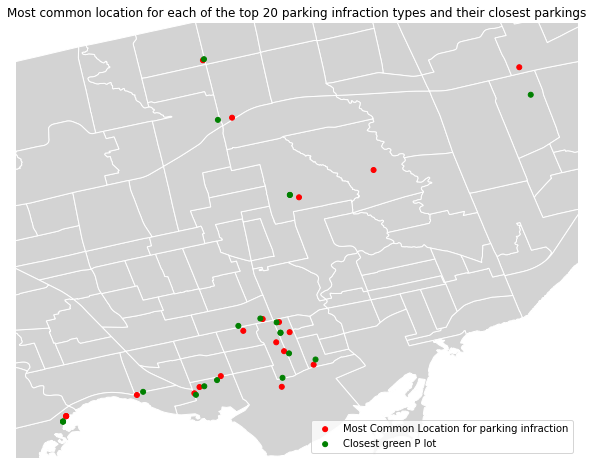

In [33]:
ax = geoplot.polyplot(neighbour_df, edgecolor="white", facecolor="lightgray",figsize=(12, 8))
geoplot.pointplot(gdf_top_20, ax = ax,color = 'red', label='Most Common Location for parking infraction')
geoplot.pointplot(gdf_top_20['parking_geometry'], ax = ax, color = 'green', label='Closest green P lot' )
plt.title("Most common location for each of the top 20 parking infraction types and their closest parkings")
plt.legend()
plt.show()

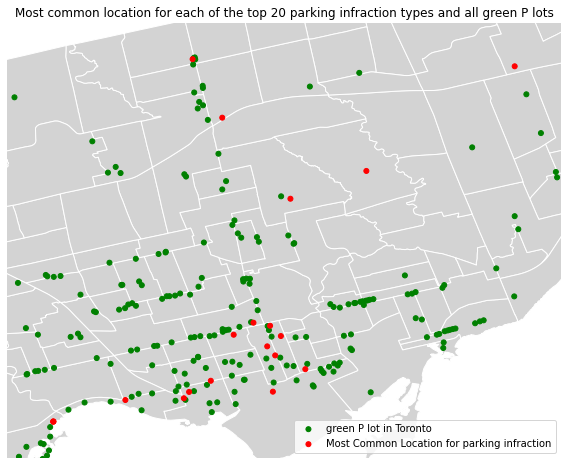

In [34]:
ax = geoplot.polyplot(neighbour_df, edgecolor="white", facecolor="lightgray",figsize=(12, 8))
geoplot.pointplot(gdf_parking, ax = ax,color = 'green', label='green P lot in Toronto')
geoplot.pointplot(gdf_top_20, ax = ax,color = 'red', label='Most Common Location for parking infraction')
plt.title("Most common location for each of the top 20 parking infraction types and all green P lots")
plt.legend()
plt.show()

## <a name='question_3'></a>Question 3: Relevant socio-demographic observation(s) related to common ticket infractions
1. Import Neighbour profile data
2. Data Processing
3. Analyze socio-demographic trends

### Q3 Step1 Import Neighbour profile data

In [35]:
url = base_url + "/api/3/action/package_show"
params = { "id": "neighbourhood-profiles"}
profile_package = requests.get(url, params = params).json()

In [36]:
# To get resource data:
for idx, resource in enumerate(profile_package["result"]["resources"]):

        # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        name = resource['name']
        filename = resource['url'].split('/')[-1]
        if name == 'neighbourhood-profiles-2016-140-model.json':
            
            resource_metadata = requests.get(url).json()

            # From here, you can use the "url" attribute to download this file
            response = requests.get(resource_metadata['result']['url'])
            
            if response.status_code == 200:
                print("Data Loaded Successfully")
            else:
                print("Failed to load data")
            
            # write the content of the response to a file             
            with open(filename, 'wb') as f:
                f.write(response.content)

Data Loaded Successfully


In [37]:
# open the file and transform to dataframe
with open('neighbourhood-profiles-2016-140-model.json') as file:
    profiledata = json.load(file)
reff = pd.json_normalize(profiledata)
profile_df = pd.DataFrame(data=reff)
profile_df.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,None,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,None,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


### Q3 Step 2 Data Processing

#### Transpose the dataframe because I want the topic to be column and the neighbour name be the row

In [38]:
# Transpose the dataframe
profile_df = profile_df.T

In [39]:
# drop the first four rows
profile_df.drop(profile_df.head(4).index, inplace=True)

In [40]:
# set the column name to the topic, and set neighbour to index
profile_df = profile_df.rename(columns=profile_df.iloc[0]).drop(profile_df.index[0])
profile_df['neighbour'] = profile_df.index
profile_df = profile_df.rename(columns=lambda x: x.strip())


In [41]:
# strip profile_df neighbour name because there are some extra spaces and remove () 
profile_df['neighbour'] = profile_df['neighbour'].str.replace(r"\s*\([^()]*\)", "", regex=True).str.strip()


In [42]:
# Remove () in neighbour_df area name so that it can merge with profile dataframe
neighbour_df['AREA_NAME'] = neighbour_df['AREA_NAME'].str.replace(r"\s*\([^()]*\)", "", regex=True).str.strip()

In [43]:
## Merge the neighbour with profile data, joining on the neighbour names:
merged_neighbour = neighbour_df.merge(profile_df, left_on="AREA_NAME", right_on="neighbour", how='left')

In [44]:
## Spatial join merged_neighbour with top 20 common place
gdf_top_20_with_profile = gpd.sjoin(gdf_top_20,merged_neighbour)

In [45]:
# extract the target neigbourhood information to a new dataframe, answer question 3 based on this dataframe
n_list = gdf_top_20_with_profile['AREA_NAME'].unique()
target_neighbour_df = profile_df[profile_df.index.isin(n_list)]
target_neighbour_df

,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),...,Interprovincial migrants,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Interprovincial migrants,External migrants,neighbour
Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,"3,075",...,90,490,"22,325","13,565","8,775","5,610","3,145",220,"2,170",Agincourt South-Malvern West
Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,"2,360",...,385,835,"27,715","12,980","14,735","8,340","6,390","1,310","2,460",Annex
Banbury-Don Mills,42,No Designation,"27,695","26,918",2.90%,"12,473","12,124","2,775",9.98,"3,605",...,75,380,"25,925","16,300","9,625","6,480","3,140",220,"1,735",Banbury-Don Mills
Bay Street Corridor,76,No Designation,"25,797","19,348",33.30%,"18,436","15,074","14,097",1.83,"1,695",...,785,"1,735","24,640","6,470","18,170","6,390","11,780","1,970","6,545",Bay Street Corridor
Bridle Path-Sunnybrook-York Mills,41,No Designation,"9,266","8,713",6.30%,"3,478","3,241","1,040",8.91,"1,435",...,60,130,"8,825","5,715","3,105","2,210",890,120,395,Bridle Path-Sunnybrook-York Mills
Church-Yonge Corridor,75,No Designation,"31,340","28,349",10.60%,"21,983","19,680","23,044",1.36,"1,260",...,585,"1,170","29,635","11,565","18,060","8,455","9,610","1,495","4,035",Church-Yonge Corridor
Moss Park,73,No Designation,"20,506","16,306",25.80%,"12,513","11,554","14,753",1.39,"1,540",...,235,500,"17,840","7,560","10,285","6,020","4,265",795,"1,325",Moss Park
Newtonbrook West,36,No Designation,"23,831","23,052",3.40%,"9,416","8,960","5,070",4.7,"2,810",...,190,960,"22,610","12,000","10,600","5,755","4,835",215,"3,475",Newtonbrook West
Niagara,82,No Designation,"31,180","21,274",46.60%,"19,660","18,774","10,156",3.07,"2,055",...,510,735,"29,250","8,790","20,475","10,830","9,640","1,790","2,255",Niagara
South Parkdale,85,NIA,"21,849","21,251",2.80%,"12,085","11,390","9,583",2.28,"2,115",...,200,420,"19,820","9,755","10,075","5,895","4,180",615,"1,670",South Parkdale


## Q3 Step 3 Are there any socio-demographic trends of note in the areas with more infractions?

Some possible socio-demographic factors:
1. Age
2. Population density
3. Unemployment rate

## Q3.1. Analyze Age: 
### Assuption: Younger drivers may be more likely to commit parking infractions due to lack of experience and knowledge of parking regulations.

In [46]:
target_neighbour_df[['Male: 20 to 24 years','Male: 45 to 49 years','Female: 20 to 24 years','Female: 45 to 49 years','neighbour']]

,Male: 20 to 24 years,Male: 45 to 49 years,Female: 20 to 24 years,Female: 45 to 49 years,neighbour
Agincourt South-Malvern West,1000,760,895,885,Agincourt South-Malvern West
Annex,1215,850,1520,855,Annex
Banbury-Don Mills,700,1010,650,1170,Banbury-Don Mills
Bay Street Corridor,2485,500,3005,555,Bay Street Corridor
Bridle Path-Sunnybrook-York Mills,345,285,325,410,Bridle Path-Sunnybrook-York Mills
Church-Yonge Corridor,1810,1205,2205,685,Church-Yonge Corridor
Moss Park,795,1020,740,550,Moss Park
Newtonbrook West,1000,775,955,975,Newtonbrook West
Niagara,880,875,1155,810,Niagara
South Parkdale,705,810,835,680,South Parkdale


In [47]:
# convert type of selected column value to float for plotting
target_neighbour_df = target_neighbour_df.copy()
target_neighbour_df['Male: 20 to 24 years'] = target_neighbour_df['Male: 20 to 24 years'].apply(pd.to_numeric,1)
target_neighbour_df['Male: 45 to 49 years'] = target_neighbour_df['Male: 45 to 49 years'].apply(pd.to_numeric,1)
target_neighbour_df['Female: 20 to 24 years'] = target_neighbour_df['Female: 20 to 24 years'].apply(pd.to_numeric,1)
target_neighbour_df['Female: 45 to 49 years'] = target_neighbour_df['Female: 45 to 49 years'].apply(pd.to_numeric,1)

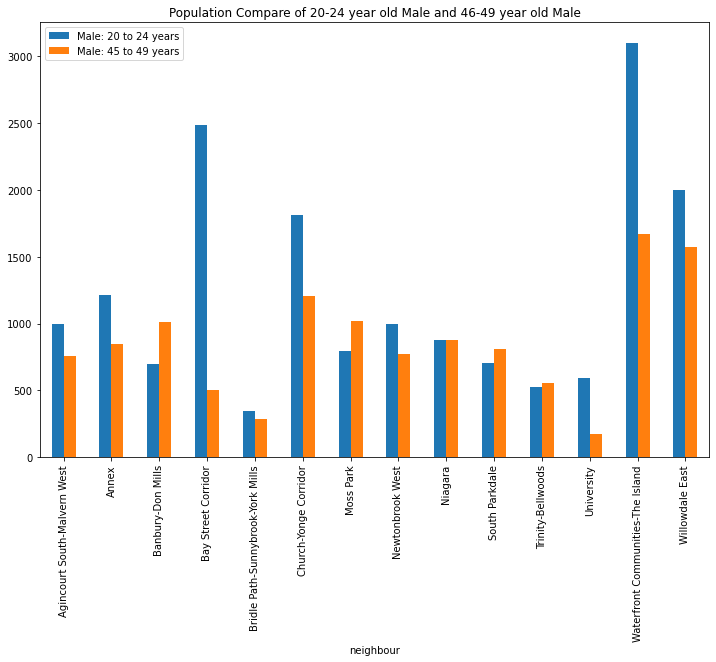

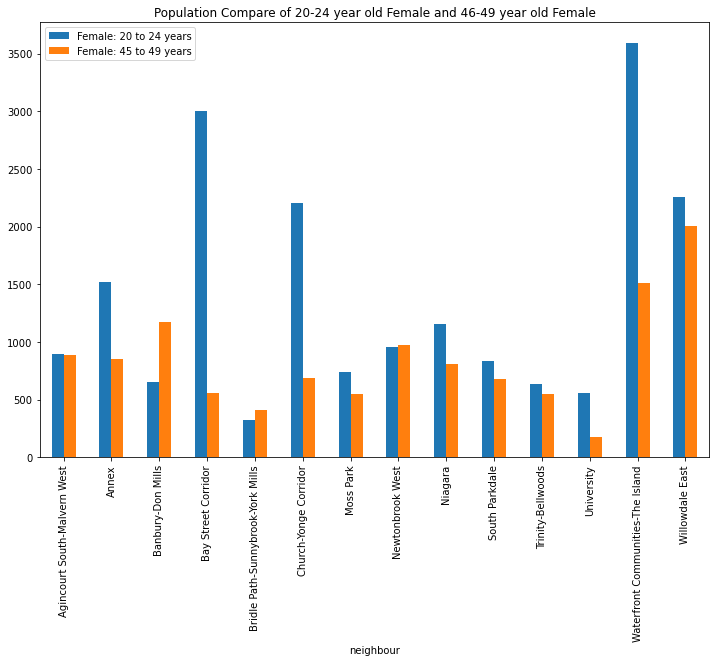

In [48]:
# plot the population of 20-24 year old Male and 46-49 year old Male and 20-24 year old Female and 46-49 year old Female in each neighbour
ax1 = target_neighbour_df.plot(x='neighbour', y=['Male: 20 to 24 years','Male: 45 to 49 years'],figsize=(12,8), kind="bar",title='Population Compare of 20-24 year old Male and 46-49 year old Male' )
ax2 = target_neighbour_df.plot(x='neighbour', y=['Female: 20 to 24 years','Female: 45 to 49 years'],figsize=(12,8), kind="bar",title='Population Compare of 20-24 year old Female and 46-49 year old Female')


### Result:  
Based on the figures: \
For most of the neighbourhoods, more young people lives in there than middle-aged people. \
\
Thus, age may be a contributing factor to the rate of parking infractions in those neighborhoods.\
It's possible that younger drivers may be more likely to commit parking infractions due to lack of experience and knowledge of parking regulations. They may also be more likely to take risks and make mistakes when parking their vehicles

## Q3.2. Analyze Population Density
### Assuption: Areas with more people living in a small space may have more cars and therefore more parking infractions.

In [49]:
target_neighbour_df[['Population density per square kilometre','neighbour']]

,Population density per square kilometre,neighbour
Agincourt South-Malvern West,"3,034",Agincourt South-Malvern West
Annex,"10,863",Annex
Banbury-Don Mills,"2,775",Banbury-Don Mills
Bay Street Corridor,"14,097",Bay Street Corridor
Bridle Path-Sunnybrook-York Mills,"1,040",Bridle Path-Sunnybrook-York Mills
Church-Yonge Corridor,"23,044",Church-Yonge Corridor
Moss Park,"14,753",Moss Park
Newtonbrook West,"5,070",Newtonbrook West
Niagara,"10,156",Niagara
South Parkdale,"9,583",South Parkdale


In [50]:
target_neighbour_df['Population density per square kilometre'] = target_neighbour_df['Population density per square kilometre'].replace({',':''},regex=True).apply(pd.to_numeric,1)

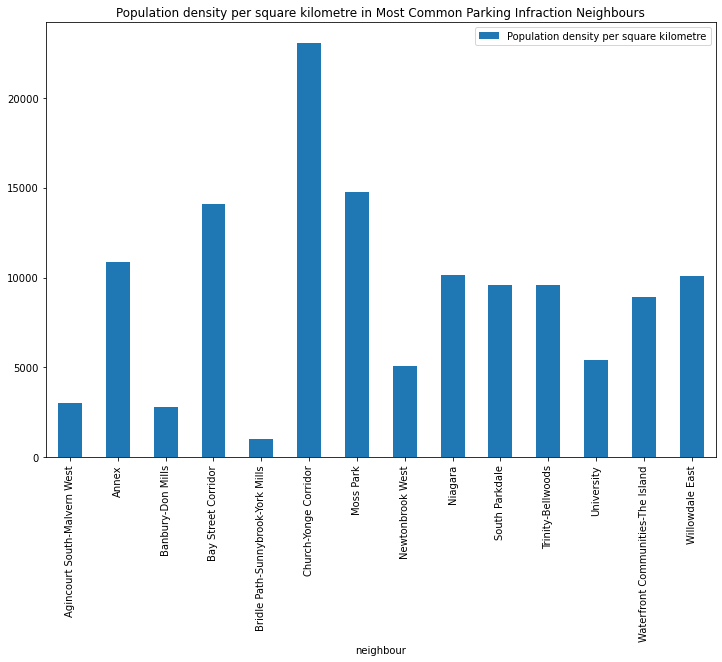

In [51]:
ax3 =target_neighbour_df.plot(x='neighbour', y=['Population density per square kilometre'],figsize=(12,8), kind="bar",title='Population density per square kilometre in Most Common Parking Infraction Neighbours' )

In [52]:
import mapclassify as mc
gdf_top_20_with_profile['Population density per square kilometre'] = gdf_top_20_with_profile['Population density per square kilometre'].replace({',':''},regex=True).apply(pd.to_numeric,1)
scheme = mc.Quantiles(gdf_top_20_with_profile['Population density per square kilometre'], k=5)

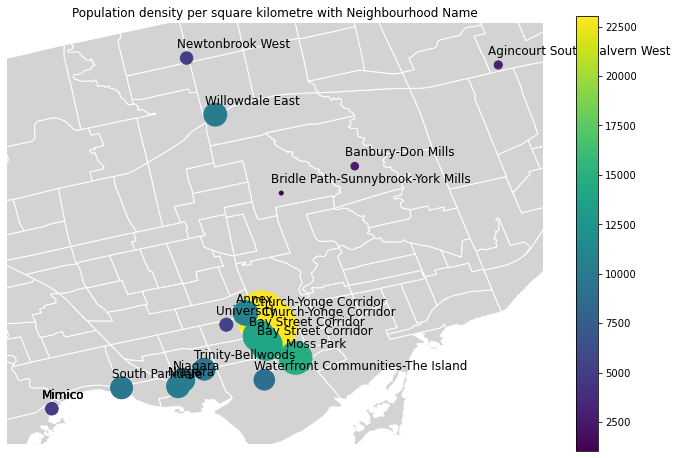

In [53]:
m = geoplot.polyplot(merged_neighbour, edgecolor="white", facecolor="lightgray",figsize=(12, 8))

gdf_top_20_with_profile.apply(lambda row: plt.annotate(row['neighbour'], xy=row.geometry.centroid.coords[0], xytext=(-10,10), textcoords='offset points', fontsize=12), axis=1)

geoplot.pointplot(
    gdf_top_20_with_profile,
    scale='Population density per square kilometre', limits=(4, 50),
    hue='Population density per square kilometre', cmap='viridis',
#     scheme=scheme,
    legend=True,
    legend_var='hue',
    ax=m
)
plt.title('Population density per square kilometre with Neighbourhood Name')
plt.show()

### Result:  
Based on the figure:\
'Bridle Path-SunnyBrook-York Mills', 'Banbury-Don Mills', and 'Agincourt South-Malvern West' these three neighbourhoods have the population density lower than 5000 people per square kilometre, other neighbourhoods have the population greater than 5000 people square kilometre.\
\
Based on the map:\
'Bridle Path-SunnyBrook-York Mills', 'Banbury-Don Mills', and 'Agincourt South-Malvern West' these three neighbourhoods are not in downtown toronto. Most of neighbourhoods that have large populaton density are located near downtown.\
\
Thus, higher population density may also be a factor to parking infractions in those neighborhoods.\
It's possible that areas with more people living in a small space may have more cars and therefore more parking infractions.

## Q3.3. Unemployment rate:
### Assuption: High unemployment rate areas may have a higher number of residents who are more likely to be unable to pay for parking that will more likely to take the risk to park illegally.

In [54]:
target_neighbour_df[['Unemployment rate','neighbour']]

,Unemployment rate,neighbour
Agincourt South-Malvern West,9.8,Agincourt South-Malvern West
Annex,6.7,Annex
Banbury-Don Mills,7.2,Banbury-Don Mills
Bay Street Corridor,10.2,Bay Street Corridor
Bridle Path-Sunnybrook-York Mills,8,Bridle Path-Sunnybrook-York Mills
Church-Yonge Corridor,8.5,Church-Yonge Corridor
Moss Park,6.9,Moss Park
Newtonbrook West,8.4,Newtonbrook West
Niagara,4.5,Niagara
South Parkdale,8.6,South Parkdale


In [55]:
target_neighbour_df['Unemployment rate'] = target_neighbour_df['Unemployment rate'].replace({',':''},regex=True).apply(pd.to_numeric,1)

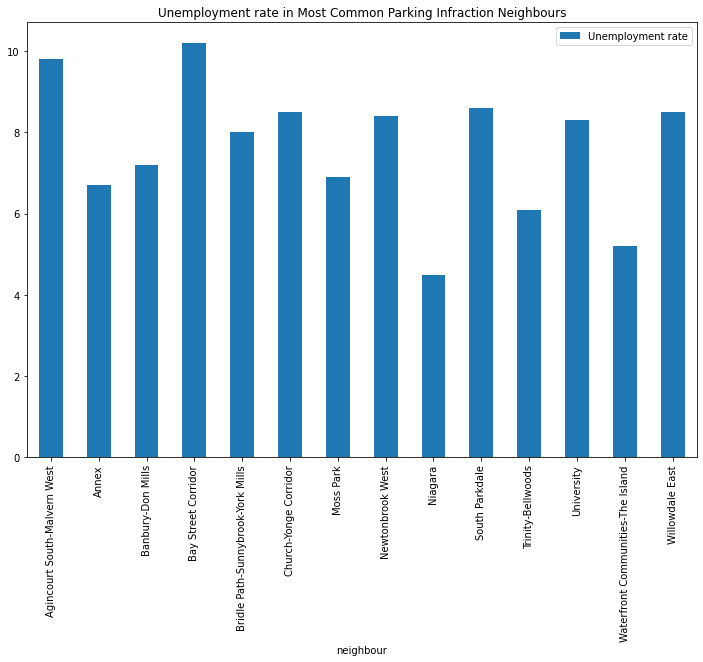

In [56]:
ax4 =target_neighbour_df.plot(x='neighbour', y=['Unemployment rate'],figsize=(12,8), kind="bar",title='Unemployment rate in Most Common Parking Infraction Neighbours' )

### Result:  
Based on the figure:\
All neighbourhoods'unemployment rates are higher than 4%, most neighbourhoods' unemployment rates are above 6% except 'Newtonbrook West' and 'Waterfront Communities-The Island'.\
\
Thus, unployment rate may also be a factor to parking infractions in those neighborhoods.\
\
High unemployment rate areas may have a higher number of residents who own older, less reliable cars that are more likely to be parked illegally.

## Conclusion:

From the analysis of age, population density, and unemployment rate, we find out that there might be a correlation between those factors and common ticket infractions in those neighbourhoods:
1. Younger drivers may be more likely to commit parking infractions due to lack of experience and knowledge of parking regulations.
2. Areas with more people living in a small space may have more cars and therefore more parking infractions.
3. High unemployment rate areas may have a higher number of residents who are more likely to be unable to pay for parking that will more likely to take the risk to park illegally.

However correlation does not imply causation, and further research would be needed to establish causality between these trends and parking infractions